# 僵尸企业识别项目
## 分类器构建与调参

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, manifold, neighbors, linear_model, ensemble, neural_network, tree, svm
from sklearn import metrics, model_selection, preprocessing, feature_selection
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


## 定义辅助函数：
- `univarTest`: 单变量相关性检验
- `plotFeatureSig`: 画图展示变量重要性
- `tryAllClassifiers`: 使用一系列模型（默认参数）进行性能对比

In [32]:
def univarTest(df, flag, method='chi2'):
  df = pd.merge(df, flag, on='ID').drop('ID', axis=1).dropna()
  df.iloc[:, :-1] = preprocessing.minmax_scale(df.iloc[:, :-1])
  methods = {
    'chi2': feature_selection.chi2,
    'f': feature_selection.f_classif,
    'mutal': feature_selection.mutual_info_classif
  }
  if method == 'mutal':
    score = methods[method](df.iloc[:, :-1], df.flag)
    sig = pd.DataFrame({'feature': df.columns[:-1], method: score, 'score': score})
  else:
    score, pv = methods[method](df.iloc[:, :-1], df.flag)
    sig = pd.DataFrame({'feature': df.columns[:-1], method: score, 'p': pv})
    sig['score'] = -np.log(sig.p)
  return sig.sort_values('score')

def plotFeatureSig(sig):
  sig.plot.barh(x='feature', y='score', grid=True, figsize=(10, 20))

def decisionTreeViz(model):
  dot_data = StringIO()
  export_graphviz(model, feature_names=features, class_names=['正常企业', '僵尸企业'],
                  out_file=dot_data, filled=True, rounded=True, special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  SVG(graph.create_svg())

def tryAllClassifers(Xtrain, Xtest, ytrain, ytest):
  # try with different classifiers
  _, axes = plt.subplots(3, 3, figsize=(14, 14))
  models = [neighbors.KNeighborsClassifier(n_neighbors=5),
            linear_model.LogisticRegression(),
            svm.SVC(),
            tree.DecisionTreeClassifier(),
            neural_network.MLPClassifier(),
            ensemble.BaggingClassifier(),
            ensemble.RandomForestClassifier(),
            ensemble.AdaBoostClassifier(),
            ensemble.GradientBoostingClassifier()]
  for ax, model in zip(axes.flatten(), models):
    clf = model.fit(Xtrain, ytrain)
    # clf = linear_model.LogisticRegression().fit(Xtrain, ytrain)
    metrics.plot_confusion_matrix(clf, Xtest, ytest, ax=ax, values_format='d')
    f1 = metrics.f1_score(y_true=ytest, y_pred=clf.predict(Xtest))
    ax.set(title=f'{type(clf).__name__}\nF1={f1:.2f}')

def tryClassifiersCV(X, y, models=None, cv=5):
  # cross validation
  if models is None:
    models = [tree.DecisionTreeClassifier(),
              ensemble.BaggingClassifier(),
              ensemble.RandomForestClassifier(),
              ensemble.AdaBoostClassifier(),
              ensemble.GradientBoostingClassifier()]
  scores = {}
  for model in models:
    score = model_selection.cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    modelName = type(model).__name__
    scores[modelName] = score
    plt.plot(score, label=modelName)
  plt.legend()

  return scores



## 读取预处理过后的数据

In [33]:
# validate -> train
trainFeatures = pd.read_hdf('dataset/preprocessed-data.h5', key='all_validate')
# trainFeatures = pd.concat([trainFeatures,
#                            pd.read_hdf('dataset/preprocessed-data.h5', key='all_validate2')])
trainLabels = pd.read_hdf('dataset/preprocessed-data.h5', key='flag_validate')
# trainLabels = pd.concat([trainLabels, 
#                          pd.read_hdf('dataset/preprocessed-data.h5', key='flag_validate2')])

testFeatures = pd.read_hdf('dataset/preprocessed-data.h5', key='all_train')
testLabels = pd.read_hdf('dataset/preprocessed-data.h5', key='flag_train')

# # train -> validate
# trainFeatures = pd.read_hdf('dataset/preprocessed-data.h5', key='all_train')
# trainLabels = pd.read_csv('dataset/infer-train-flag.csv')
# testFeatures = pd.read_hdf('dataset/preprocessed-data.h5', key='all_validate')
# testLabels = pd.read_hdf('dataset/preprocessed-data.h5', key='flag_validate')

inferenceFeatures = pd.read_hdf('dataset/preprocessed-data.h5', key='all_test')

# TRAIN_SAMPLES = 4000
# TEST_SAMPLES = 1000


## 变量选择
分别使用卡方检验、单变量分析（ANOVA）、互信息来刻画特征与目标变量之间的关系

In [34]:
# feature selection
features = set()

# # drop features with ultra low variance
# scaledFeatures = preprocessing.minmax_scale(trainFeatures, axis=0)
# varTest = pd.DataFrame({'feature': trainFeatures.columns, 
#                         'score': np.var(scaledFeatures, axis=0)}).sort_values('score')
# # selected threshold: 0.01
# # features -= set(var[var<0.01].index)

# add features with high correlation with the flag
chi2Test = univarTest(trainFeatures, trainLabels, 'chi2')
# threshold: 0.01 (p)
features |= set(chi2Test.feature[chi2Test.p < 0.01])

fTest = univarTest(trainFeatures, trainLabels, 'f')
# threshold: 0.001 (p)
features |= set(fTest.feature[fTest.p < 0.001])

mutalTest = univarTest(trainFeatures, trainLabels, 'mutal')
# threshold: 0.2 (mutal-information)
features |= set(mutalTest.feature[mutalTest.score > 0.2])


/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


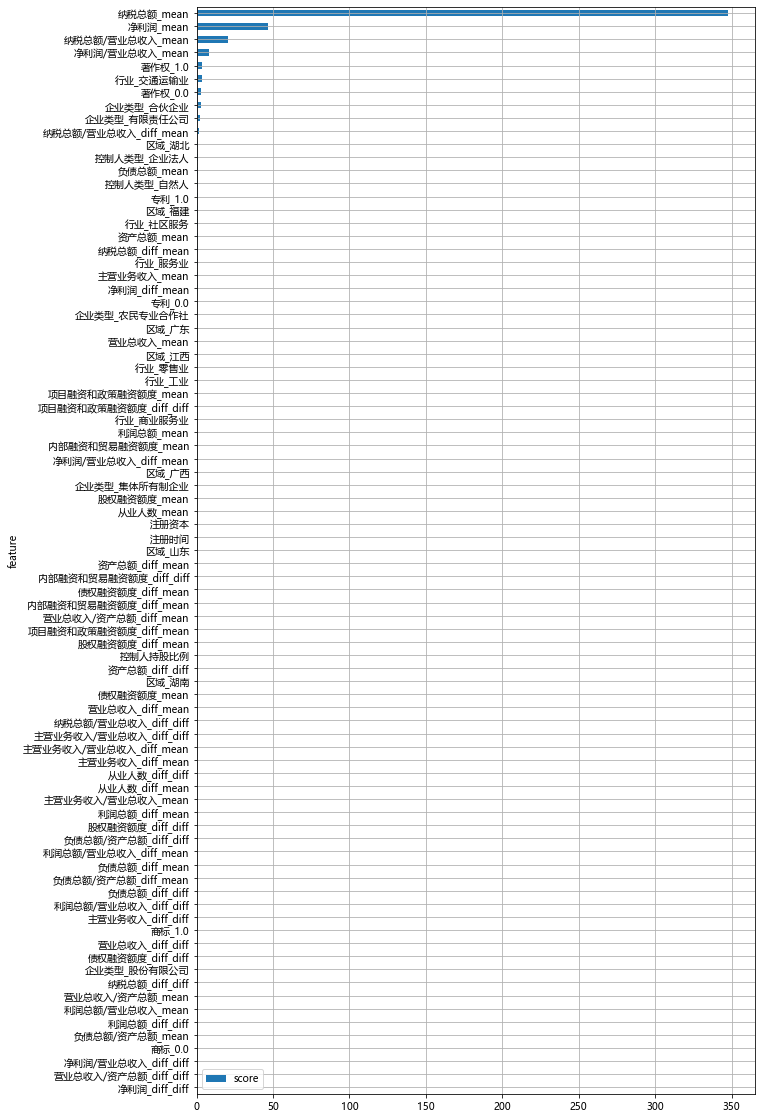

In [36]:
plotFeatureSig(chi2Test)

In [38]:
features

Index(['纳税总额_diff_diff', '净利润/营业总收入_diff_diff', '纳税总额/营业总收入_diff_diff',
       '纳税总额/营业总收入_diff_mean', '净利润/营业总收入_mean', '纳税总额_mean', '纳税总额_diff_mean',
       '净利润_mean', '净利润_diff_mean', '净利润/营业总收入_diff_mean', '纳税总额/营业总收入_mean'],
      dtype='object')

In [37]:
trainFeatures = trainFeatures[['ID'] + list(features)]
testFeatures = testFeatures[['ID'] + list(features)]
inferenceFeatures = inferenceFeatures[['ID'] + list(features)]

trainSet = pd.merge(trainFeatures, trainLabels, how='inner', on='ID')
trainSet = trainSet.dropna().set_index('ID')
testSet = pd.merge(testFeatures, testLabels, how='inner', on='ID')
testSet = testSet.set_index('ID')
inferenceFeatures = inferenceFeatures.set_index('ID')

features = trainSet.columns[:-1]


In [39]:
# prepare data

# trainSet = trainSet.sample(TRAIN_SAMPLES)
X, y = trainSet.drop('flag', axis=1), trainSet.flag

X, y = RandomUnderSampler().fit_resample(X, y)
# X, y = SMOTE().fit_resample(X, y)
# self-labeling
# Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size=0.2)

# # %%
# # compare up and down sampling
# # up-sampling
# XtrainUp, ytrainUp = SMOTE().fit_resample(X, y)
# # under-sampling
# XtrainDown, ytrainDown = RandomUnderSampler().fit_resample(X, y)

# model = linear_model.LogisticRegression()
# plt.plot(model_selection.cross_val_score(model, XtrainUp, ytrainUp, cv=100, n_jobs=-1), label='upsampling')
# plt.plot(model_selection.cross_val_score(model, XtrainDown, ytrainDown, cv=100, n_jobs=-1), label='downsampling')
# plt.legend()


/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


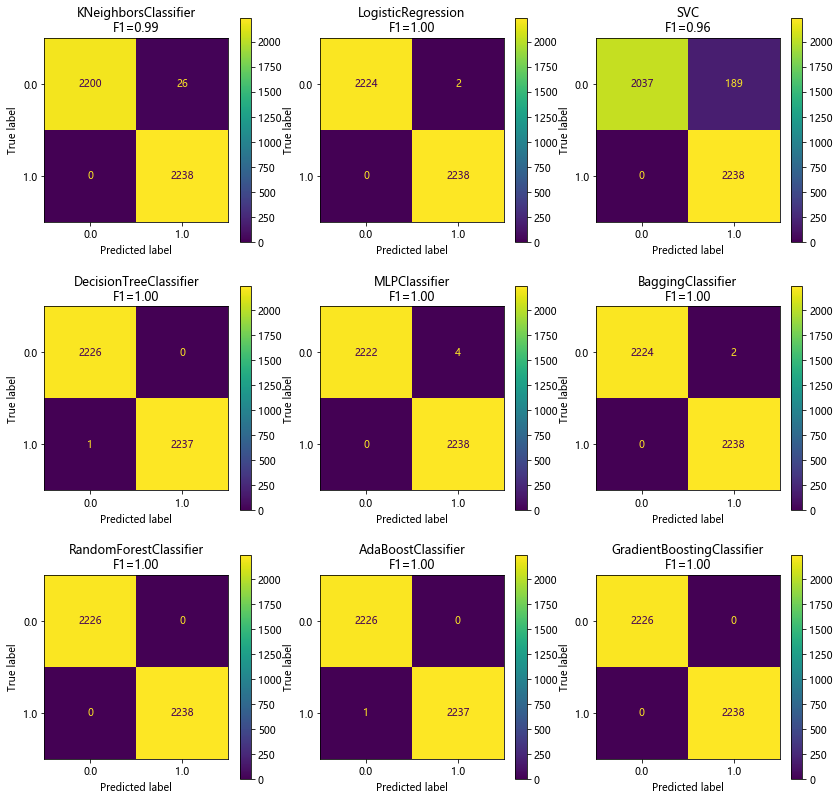

In [40]:
tryAllClassifers(*model_selection.train_test_split(X, y))

/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


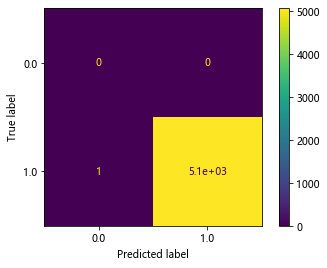

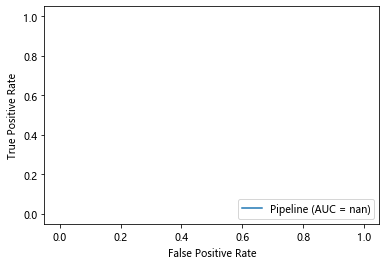

In [41]:
# rough test for GBDT
pipe = Pipeline([('scaler', preprocessing.StandardScaler()),
                 ('GBDT', ensemble.GradientBoostingClassifier(n_estimators=110, learning_rate=0.2, 
                                                              max_depth=4, min_samples_leaf=125, 
                                                              min_samples_split=196, subsample=0.57))])
# cross-validation
selfScores = model_selection.cross_val_score(pipe, X, y, cv=10, n_jobs=-1)
# on test set
pipe.fit(X, y)

testSet = testSet.dropna()
Xtest, ytest = testSet.drop('flag', axis=1), testSet.flag
metrics.plot_confusion_matrix(pipe, Xtest, ytest)
metrics.plot_roc_curve(pipe, Xtest, ytest)


In [ ]:
joblib.dump(pipe, 'models/GBDT-pipe-from-train.pkl')
inference = pipe.predict(inferenceFeatures.drop('ID', axis=1))
inferenceFlag = pd.DataFrame({'ID': inferenceFeatures.ID, 'flag': inference})
inferenceFlag.flag = inferenceFlag.flag.astype('int')
inferenceFlag.to_csv('results/infer-test-flag-from-train.csv', index=False)


In [42]:
# GBDT param searching
paramScores = {}
# gbmBaseline = ensemble.GradientBoostingClassifier()
treeBaseline = tree.DecisionTreeClassifier()
prediction = model_selection.cross_val_predict(treeBaseline, X, y, cv=10, n_jobs=-1)
hardIdx = prediction != y
linearBaseline = linear_model.LogisticRegression()
prediction = model_selection.cross_val_predict(linearBaseline, X, y, cv=10)
hardIdx |= prediction != y
randomIdx = np.random.choice([True, False], y.shape, p=[0.4, 0.6])
idx = hardIdx | randomIdx

Xhard, yhard = X[idx], y[idx]



/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/miosolo/bin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

In [43]:
def plotRangeScore(ran, gridSearch):
  plt.plot(ran, gridSearch.cv_results_['mean_test_score'])


In [44]:
# n-estimators: 110
estimatorRange = list(range(1, 2, 20)) + list(range(20, 200, 10))
paramSearch1 = {'n_estimators': estimatorRange}
gridSearch1 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(learning_rate=0.2),
                                           cv=5, scoring='f1', param_grid=paramSearch1, n_jobs=-1, verbose=1)
gridSearch1.fit(X, y)


Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   23.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

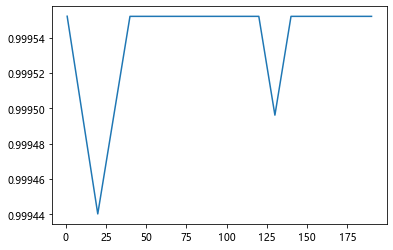

In [45]:
plotRangeScore(estimatorRange, gridSearch1)

In [46]:
# learning rate: 0.21
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
lrRange = np.arange(0.01, 1.01, 0.02)
paramSearch2 = {'learning_rate': lrRange}
gridSearch2 = model_selection.GridSearchCV(ensemble.HistGradientBoostingClassifier(),
                                           cv=5, scoring='f1', param_grid=paramSearch2, n_jobs=-1, verbose=1)
gridSearch2.fit(X, y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=HistGradientBoostingClassifier(l2_regularization=0.0,
                                                      learning_rate=0.1,
                                                      loss='auto', max_bins=255,
                                                      max_depth=None,
                                                      max_iter=100,
                                                      max_leaf_nodes=31,
                                                      min_samples_leaf=20,
                                                      n_iter_no_change=None,
                                                      random_state=None,
                                                      scoring=None, tol=1e-07,
                                                      validation_fraction=0.1,
                                                      verbose=0,
                                                      warm_start=False),
 

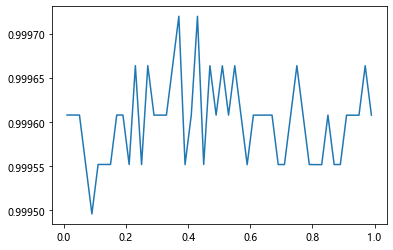

In [47]:
plotRangeScore(lrRange, gridSearch2)

In [48]:
# tree depth: 4; min_samples_split: 196
paramSearch3 = {'max_depth':range(2,5,1), 'min_samples_split':range(2, 220, 10)}
gridSearch3 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(learning_rate=0.2),
                                           cv=3, scoring='f1', param_grid=paramSearch3, n_jobs=-1, verbose=1)
gridSearch3.fit(X, y)


Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:   51.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.2,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

[Text(31.0, 0.5, 'max_depth'), Text(0.5, 4.0, 'min_samples_split')]

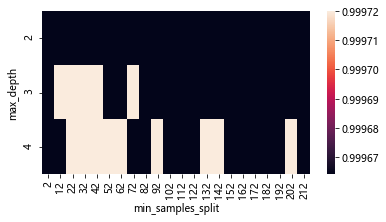

In [49]:
df = pd.DataFrame(data=gridSearch3.cv_results_['mean_test_score'].reshape(3, 22), index=range(2,5,1), columns=range(2, 220, 10))
fig = plt.figure(figsize=(6,3))
g = sns.heatmap(df)
g.set(ylabel='max_depth', xlabel='min_samples_split')


In [50]:
# min_samples_leaf: 125
paramSearch4 = {'min_samples_leaf': range(1,200,2), 'max_depth':range(2,6,1)}
gridSearch4 = model_selection.GridSearchCV(ensemble.HistGradientBoostingClassifier(learning_rate=0.2, max_depth=3),
  cv=5, scoring='f1', param_grid=paramSearch4, n_jobs=-1, verbose=1)
gridSearch4.fit(X, y)


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=HistGradientBoostingClassifier(l2_regularization=0.0,
                                                      learning_rate=0.2,
                                                      loss='auto', max_bins=255,
                                                      max_depth=3, max_iter=100,
                                                      max_leaf_nodes=31,
                                                      min_samples_leaf=20,
                                                      n_iter_no_change=None,
                                                      random_state=None,
                                                      scoring=None, tol=1e-07,
                                                      validation_fraction=0.1,
                                                      verbose=0,
                                                      warm_start=False),
             iid='deprecated', n_jobs=-1,
             par

[Text(157.0, 0.5, 'max_depth'), Text(0.5, 40.0, 'min_samples_leaf')]

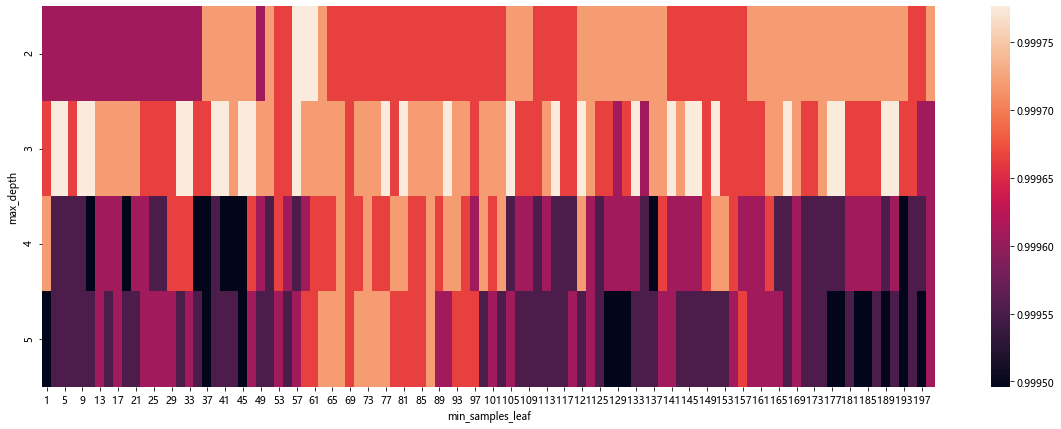

In [51]:
df = pd.DataFrame(data=gridSearch4.cv_results_['mean_test_score'].reshape(4, 100), columns=range(1,200,2), index=range(2,6,1))
fig = plt.figure(figsize=(20, 7))
g = sns.heatmap(df)
g.set(ylabel='max_depth', xlabel='min_samples_leaf')


In [ ]:
# subsample: 0.57
paramSearch5 = {'subsample': np.arange(0.55, 0.85, 0.01)}
gridSearch5 = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(
  n_estimators=110, learning_rate=0.2, max_depth=3, min_samples_leaf=125, min_samples_split=196),
  cv=5, scoring='f1', param_grid=paramSearch5, n_jobs=-1, verbose=1)
gridSearch5.fit(X, y)



Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s


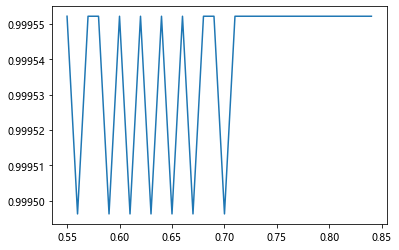

In [53]:
plotRangeScore(np.arange(0.55, 0.85, 0.01), gridSearch5)

In [ ]:
bestModel = ensemble.GradientBoostingClassifier(
  n_estimators=110, learning_rate=0.2, max_depth=4, min_samples_leaf=125, min_samples_split=196, subsample=0.57)
basicModel = ensemble.GradientBoostingClassifier()
bestModelScores = model_selection.cross_val_score(bestModel, X, y, cv=20, n_jobs=-1)
basicModelScores = model_selection.cross_val_score(basicModel, X, y, cv=20, n_jobs=-1)


In [ ]:
plt.plot(bestModelScores, label='best')
plt.plot(basicModelScores, label='basic')
plt.legend()


In [ ]:
bestModel = ensemble.GradientBoostingClassifier(
  n_estimators=110, learning_rate=0.2, max_depth=3, min_samples_leaf=125, min_samples_split=196, subsample=0.57)
bestModel.fit(X, y)